# Initialization

In [1]:
!pip install git+https://github.com/ecoscape-earth/ecoscape-connectivity.git
!pip install git+https://github.com/ecoscape-earth/ecoscape-utils.git

  Cloning https://github.com/ecoscape-earth/ecoscape-connectivity.git to /tmp/pip-req-build-yz7e5die
  Running command git clone --filter=blob:none --quiet https://github.com/ecoscape-earth/ecoscape-connectivity.git /tmp/pip-req-build-yz7e5die
  Resolved https://github.com/ecoscape-earth/ecoscape-connectivity.git to commit 6416cd24381fa26dbc48cd949c663528df2f675c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.6 MB/s eta 0:00:00
  Created wheel for ecoscape-connectivity: filename=ecoscape_connectivity-0.0.2-py3-none-any.whl size=11043 sha256=4095f1f0daada803b7398a608fe6b4c2e388bb301d0df52c0ffd96d4cb29a587
  Stored in directory: /tmp/pip-ephem-wheel-cache-z1zf7xtr/wheels/72/73/2c/f3b584a638e8a6a37479ac7d8823cb5a88a277b40f8c2732f4
Successfully built ecoscape-connectivity
  Cloning https://github.com

In [2]:
import os
import sys
import numpy as np
import torch
from torch import nn
import torch.functional as F
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import ecoscape_connectivity

In [3]:
if(torch.cuda.is_available()):
    torch.cuda.set_device(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cuda


# Simulated landscapes

In [4]:
def simulate(hab, ter,
             seed_density=4.0, batch_size=5, total_spreads=25, num_simulations=400, hop_length=1):
    """
    Function that makes simulating and displaying repopulation easier.
    """

    # analyze_tile expects the habitat to be of shape (1, w, h)
    if np.ndim(hab) == 2:
        hab = np.expand_dims(hab, axis=0)

    repopulate = ecoscape_connectivity.analyze_tile_torch(device=device,
            produce_gradient=True,
            seed_density=seed_density,
            batch_size=batch_size,
            total_spreads=total_spreads,
            num_simulations=num_simulations,
            hop_length=hop_length)

    repop, grad = repopulate(hab, ter)

    # a bit of reshaping for displaying with matplotlib
    hab = np.sum(hab, 0)
    repop = np.sum(repop.detach().cpu().numpy(), 0)
    grad = np.log2(1 + np.sum(grad.detach().cpu().numpy(), 0))

    return repop, grad

In [5]:
def draw_circle(hab, y, x, r):
    return np.maximum(hab, (X - x) ** 2 + (Y - y) ** 2 < r ** 2)

In [6]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

inferno = cm.inferno(np.linspace(0, 1, 256))
last_color = inferno[-1]
last_r, last_g, last_b, _ = last_color

cdict = {
    'red': (
        (0.0,  0.0, 0.0),
        (0.99,  0.0, 0.0),
        (1.0, last_r, last_r),
    ),
    'green': (
        (0.0,  0.0, 0.0),
        (0.99,  1.0, 1.0),
        (1.0, last_g, last_g),
    ),
    'blue': (
        (0.0,  0.0, 0.0),
        (0.99,  0.0, 0.0),
        (1.0,  last_b, last_b),
    )
}
green_cmap = LinearSegmentedColormap('green_cmap', cdict)

In [7]:
import matplotlib.cm as cm

inferno = cm.inferno(np.linspace(0, 1, 256))
last_color = inferno[-1]
last_color

array([0.988362, 0.998364, 0.644924, 1.      ])

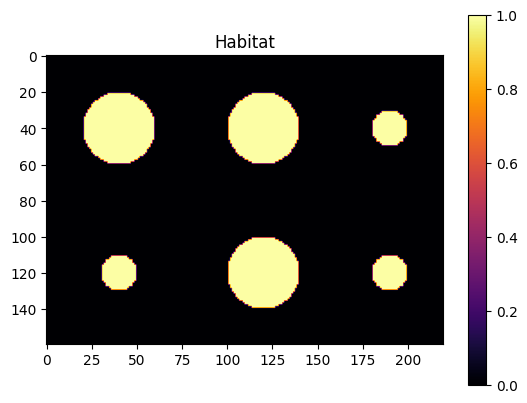

In [8]:
# habitat for testing resistance vs dispersal distance
Xdim = 220
Ydim = 160

Y, X = np.meshgrid(range(0, Xdim), range(0, Ydim))

hab = np.zeros((Ydim, Xdim))
hab = draw_circle(hab, 40, 120, 10) # c1
hab = draw_circle(hab, 120, 120, 20) # c2
hab = draw_circle(hab, 190, 120, 10) # c3
hab = draw_circle(hab, 190, 40, 10) # c4
hab = draw_circle(hab, 120, 40, 20) # c5
hab = draw_circle(hab, 40, 40, 20) # c6

plt.imshow(hab, cmap='inferno')
plt.colorbar()
plt.title('Habitat')
plt.show()

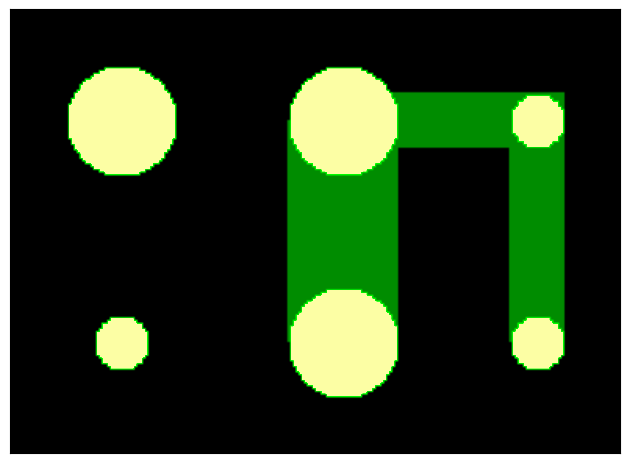

In [9]:
corridor = 0.98
ter = np.zeros_like(hab)
ter[40:120, 100:140] = corridor
ter[40:120, 180:200] = corridor
ter[30:50, 120:200] = corridor

total = np.maximum(hab, ter)
plt.imshow(total ** 30, cmap=green_cmap)
# plt.title('Habitat and terrain')
# Remove x tiks from the plot
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("artificial_landscape.pdf", format="pdf")

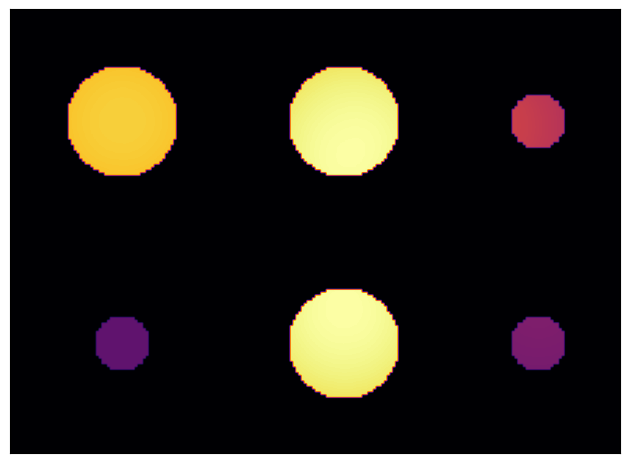

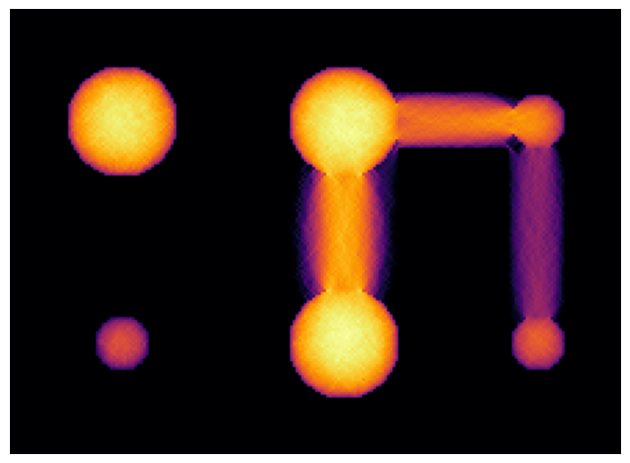

In [10]:
repop, grad = simulate(hab, ter,
             seed_density=40.0, batch_size=200, total_spreads=120, num_simulations=2000, hop_length=1)
plt.imshow(repop, cmap='inferno')
# plt.colorbar(shrink=0.5)
# plt.title("Repopulation")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("connectivity.pdf", format="pdf")
plt.show()
plt.imshow(grad, cmap='inferno')
# plt.colorbar(shrink=0.5)
# plt.title("Flow")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("flow.pdf", format="pdf")
plt.show()